<a href="https://colab.research.google.com/github/RoiRT/handwrite/blob/master/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from Tools import *

In [ ]:
dataset = tfds.load('emnist/balanced', split='train', shuffle_files=True)

x_train, y_train = cargar_datos(dataset)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/112800 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/balanced/3.0.0.incompleteDCVURB/emnist-train.tfrecord*...:   0%|   …

Generating test examples...:   0%|          | 0/18800 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/balanced/3.0.0.incompleteDCVURB/emnist-test.tfrecord*...:   0%|    …

Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/balanced/3.0.0. Subsequent calls will reuse this data.


In [ ]:
def build_generator():
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Dense(512 * 7 * 7, activation="relu", input_dim=100))
    model.add(tf.keras.layers.Reshape((7, 7, 512)))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
    model.add(tf.keras.layers.Conv2DTranspose(256, kernel_size=3, strides=(2, 2), padding="same", activation="relu"))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
    model.add(tf.keras.layers.Conv2DTranspose(128, kernel_size=3, strides=(2, 2), padding="same", activation="relu"))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
    model.add(tf.keras.layers.Conv2DTranspose(64, kernel_size=3, padding="same", activation="relu"))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
    model.add(tf.keras.layers.Conv2DTranspose(1, kernel_size=3, padding='same', activation="sigmoid"))

    noise = tf.keras.layers.Input(shape=(100,))
    label = tf.keras.layers.Input(shape=(1,), dtype='int8')
    label_embedding = tf.keras.layers.Flatten()(tf.keras.layers.Embedding(47, 100)(label))

    model_input = tf.keras.layers.multiply([noise, label_embedding])
    img = model(model_input)

    return tf.keras.models.Model([noise, label], img)

def build_discriminator():

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(16, kernel_size=3, strides=(2, 2), padding="same", activation=tf.keras.layers.LeakyReLU(alpha=0.2), input_shape=(28, 28, 1)))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras. layers.BatchNormalization(momentum=0.8))
    model.add(tf.keras.layers.Conv2D(32, kernel_size=3, strides=(2, 2), padding="same", activation=tf.keras.layers.LeakyReLU(alpha=0.2)))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
    model.add(tf.keras.layers.Conv2D(64, kernel_size=3, strides=(2, 2), padding="same", activation=tf.keras.layers.LeakyReLU(alpha=0.2)))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
    model.add(tf.keras.layers.Conv2D(128, kernel_size=3, padding="same", activation=tf.keras.layers.LeakyReLU(alpha=0.2)))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.BatchNormalization(momentum=0.8))
    model.add(tf.keras.layers.Conv2D(256, kernel_size=3, padding="same", activation=tf.keras.layers.LeakyReLU(alpha=0.2)))

    model.add(tf.keras.layers.Flatten())

    img = tf.keras.layers.Input(shape=(28, 28, 1))

    # Extract feature representation
    features = model(img)

    # Determine validity and label of the image
    validity = tf.keras.layers.Dense(1, activation="sigmoid")(features)
    label = tf.keras.layers.Dense(47, activation="softmax")(features)

    return tf.keras.models.Model(img, [validity, label])

generator = build_generator()
discriminator = build_discriminator()

GAN_model = tf.keras.models.Model(
    inputs=[generator.input[0], generator.input[1]],
    outputs=[discriminator(generator.output)[0], discriminator(generator.output)[1]]
)

In [ ]:
generator.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss='binary_crossentropy'
)
discriminator.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss=['binary_crossentropy', 'sparse_categorical_crossentropy'],
    metrics=['accuracy']
)
GAN_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
    loss=['binary_crossentropy', 'sparse_categorical_crossentropy'],
)

Se han truncado las últimas 5000 líneas del flujo de salida.
8/8 [==============================] - 0s 8ms/step
Progress errors: dError_reals= 1.1657373905181885, dError_fake= 2.672295570373535, gError= 0.7857475280761719
Progress accuracy: acc_validity_reals= 0.90234375, acc_validity_fake= 0.125, acc_label= 0.8671875
Epoch 19752
8/8 [==============================] - 0s 7ms/step
Progress errors: dError_reals= 0.9099377393722534, dError_fake= 2.705670118331909, gError= 0.8966950178146362
Progress accuracy: acc_validity_reals= 0.91015625, acc_validity_fake= 0.12109375, acc_label= 0.892578125
Epoch 19753
8/8 [==============================] - 0s 7ms/step
Progress errors: dError_reals= 1.0433074235916138, dError_fake= 2.555366039276123, gError= 0.7990484237670898
Progress accuracy: acc_validity_reals= 0.875, acc_validity_fake= 0.125, acc_label= 0.896484375
Epoch 19754
8/8 [==============================] - 0s 9ms/step
Progress errors: dError_reals= 1.039320945739746, dError_fake= 2.551483

/content/Tools.py:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(5, 10, figsize=(10, 5))


Se han truncado las últimas 5000 líneas del flujo de salida.
Progress accuracy: acc_validity_reals= 0.859375, acc_validity_fake= 0.1328125, acc_label= 0.859375
Epoch 28752
8/8 [==============================] - 0s 8ms/step
Progress errors: dError_reals= 1.0645034313201904, dError_fake= 2.833120822906494, gError= 1.4383578300476074
Progress accuracy: acc_validity_reals= 0.91796875, acc_validity_fake= 0.09765625, acc_label= 0.875
Epoch 28753
8/8 [==============================] - 0s 8ms/step
Progress errors: dError_reals= 1.2930636405944824, dError_fake= 2.886627197265625, gError= 1.208640217781067
Progress accuracy: acc_validity_reals= 0.87890625, acc_validity_fake= 0.125, acc_label= 0.869140625
Epoch 28754
8/8 [==============================] - 0s 8ms/step
Progress errors: dError_reals= 1.2766804695129395, dError_fake= 2.4131133556365967, gError= 1.323578119277954
Progress accuracy: acc_validity_reals= 0.92578125, acc_validity_fake= 0.21875, acc_label= 0.8359375
Epoch 28755
8/8 [======

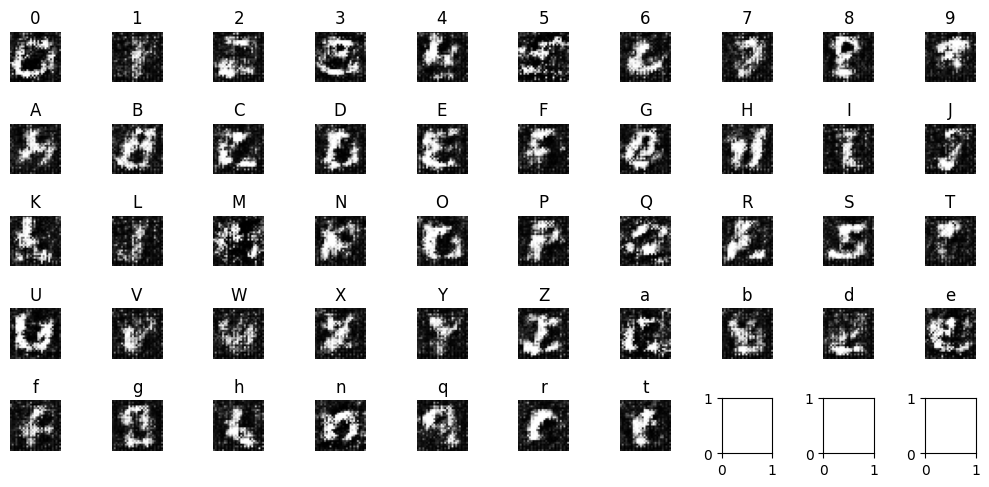

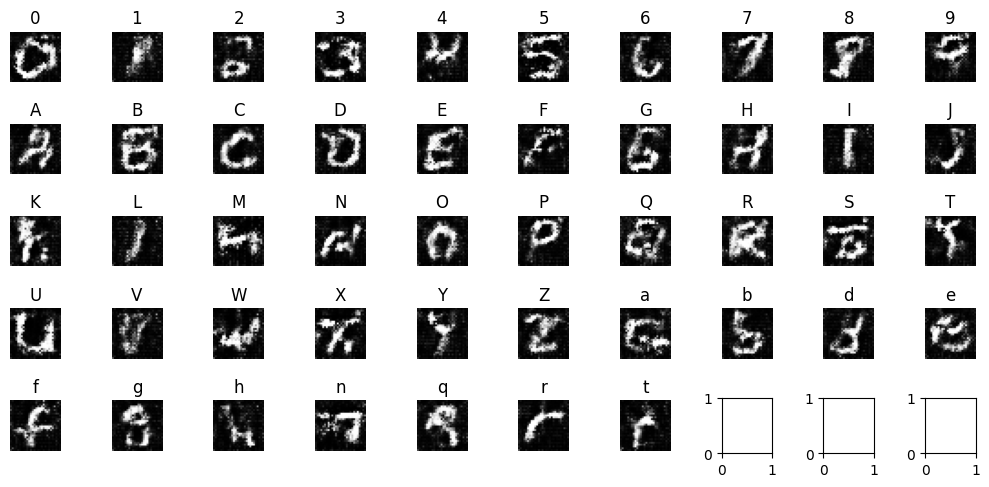

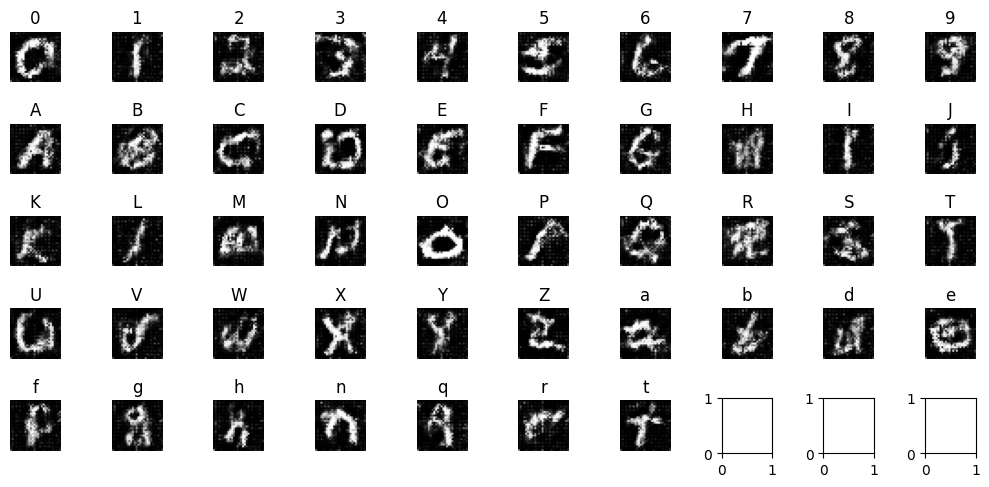

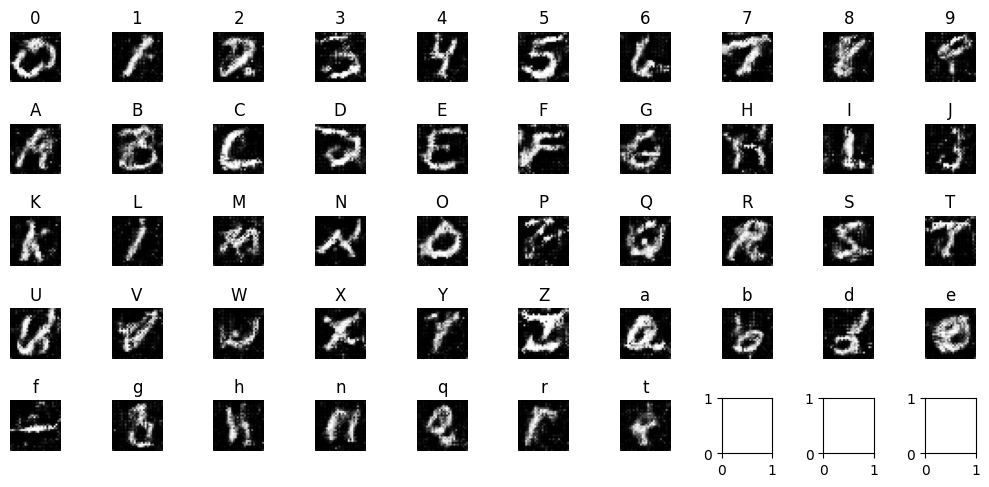

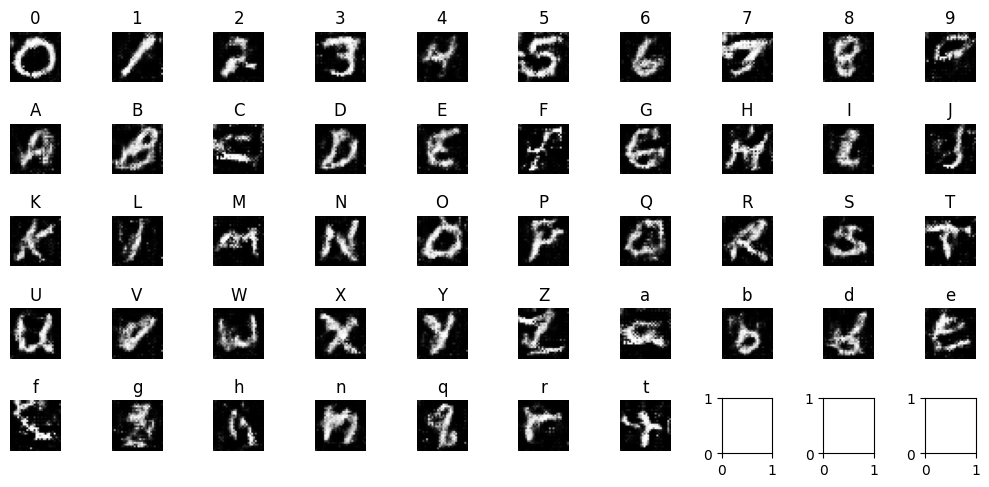

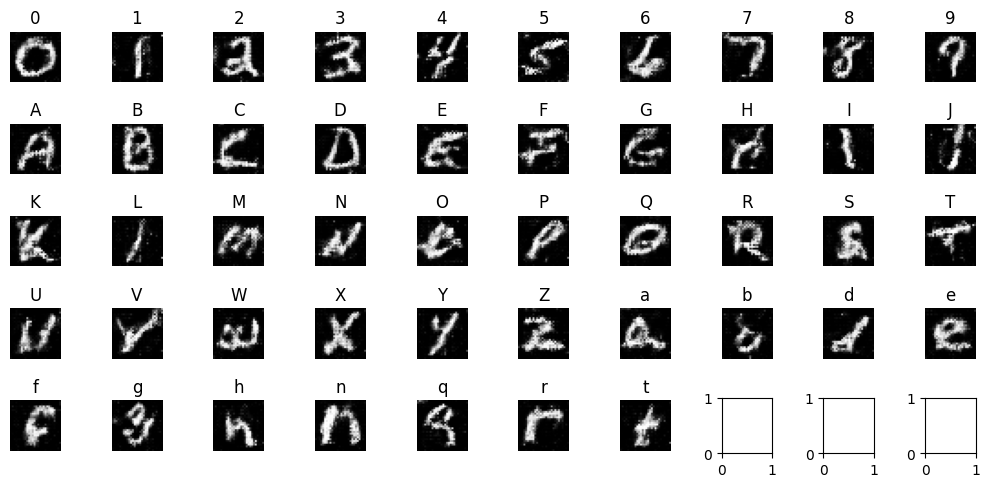

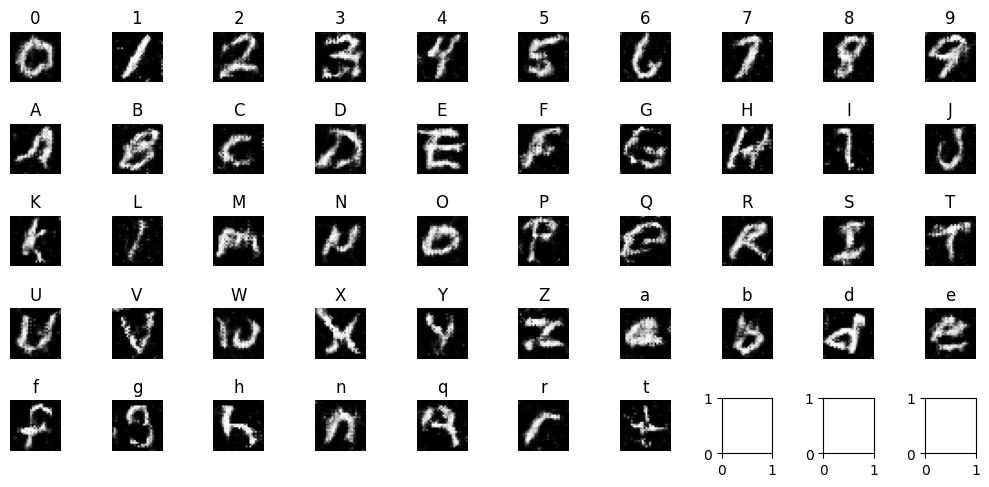

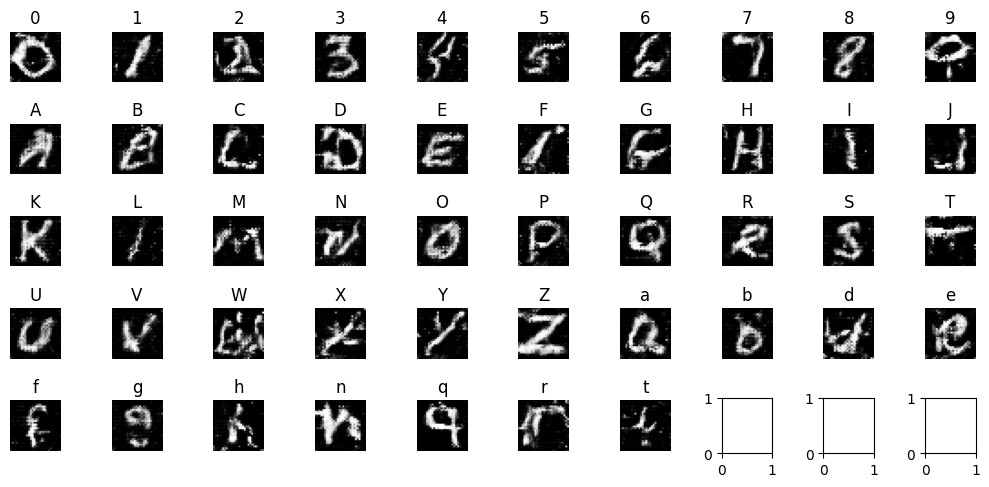

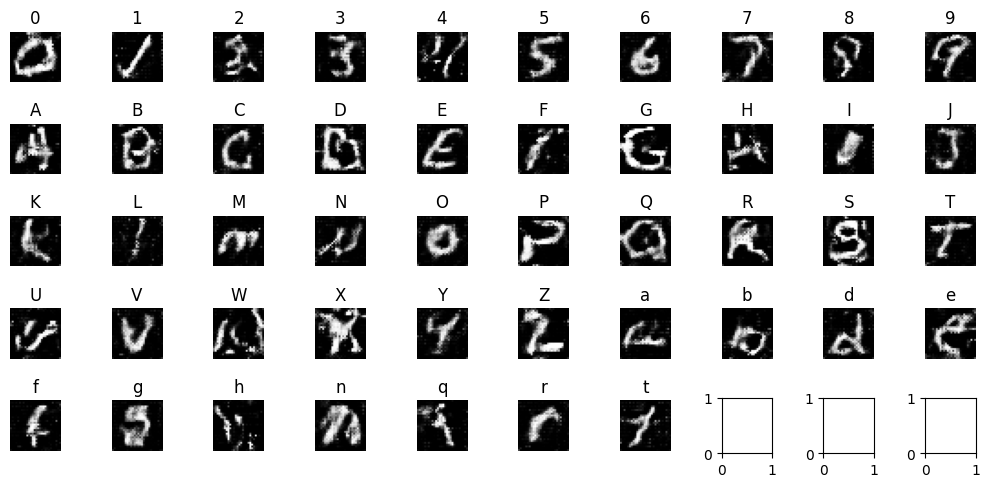

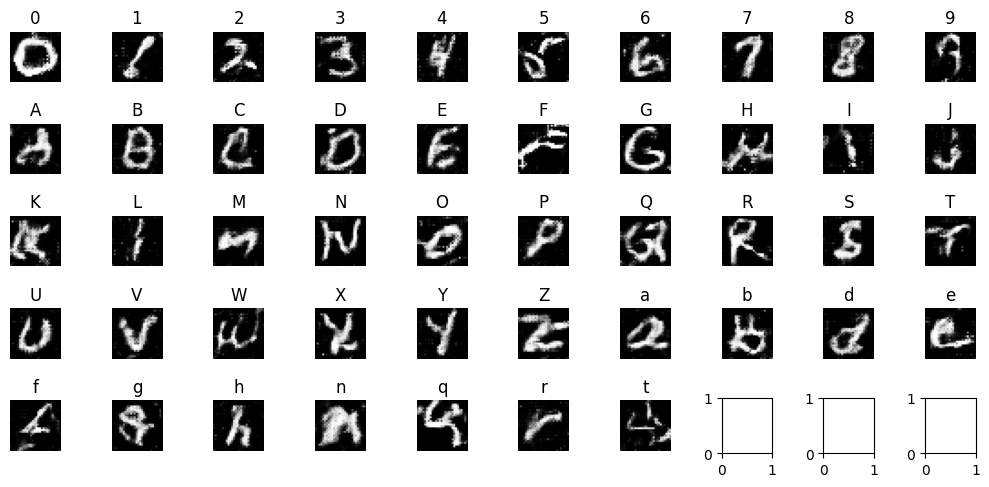

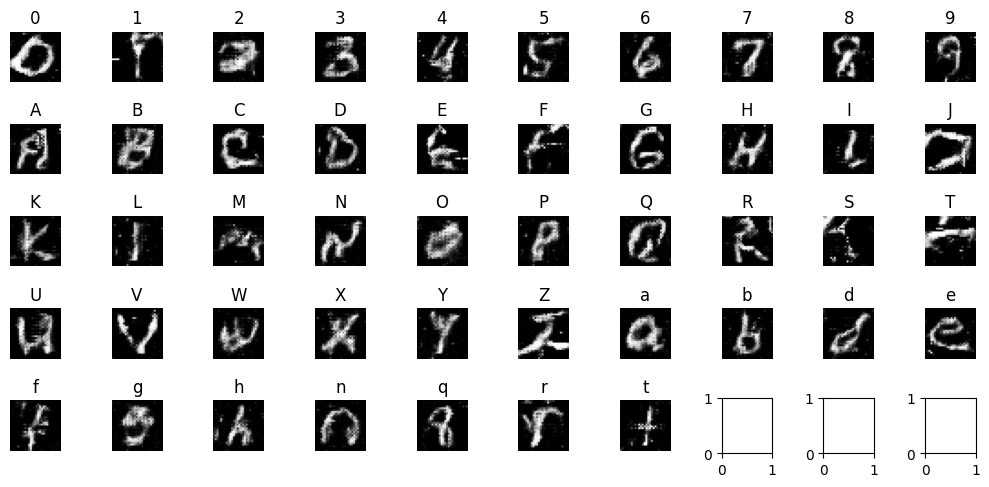

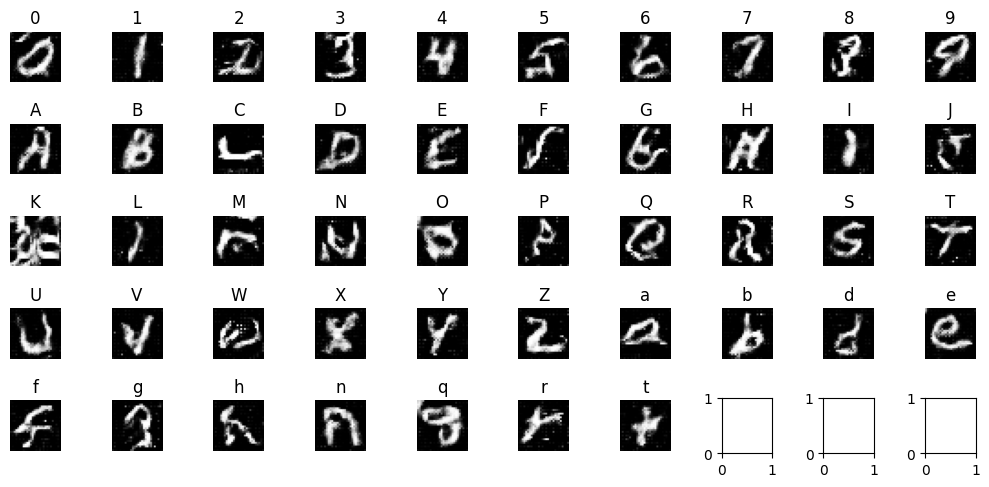

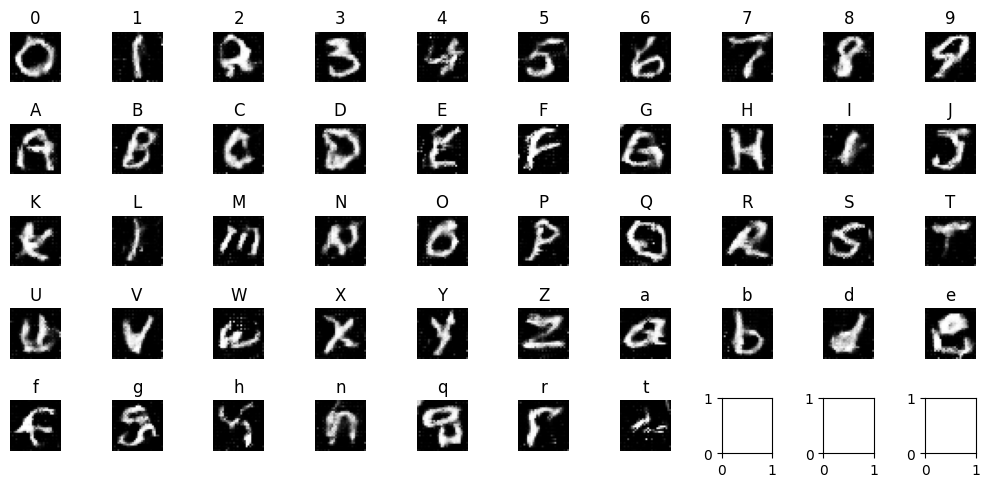

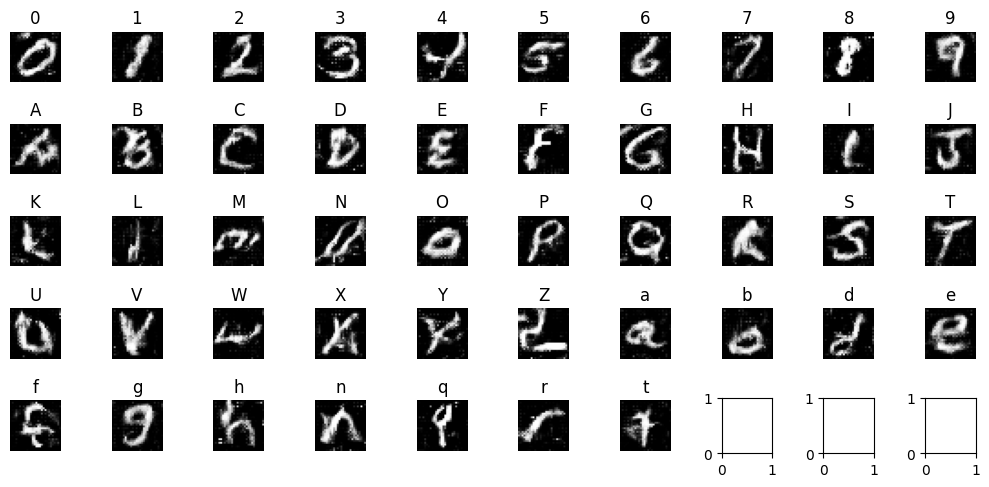

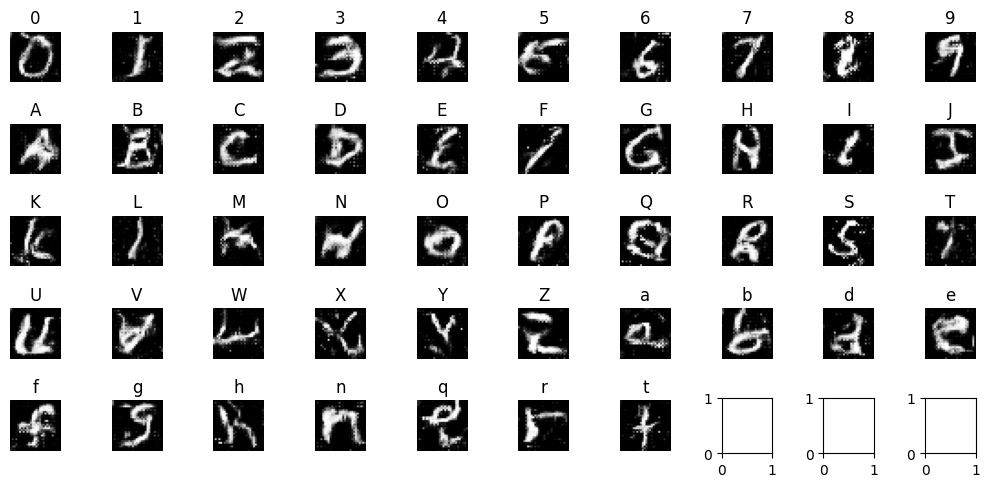

In [10]:
BATCH_SIZE = 256
N_EPOCH = 30000

errorsB = []
errorsC = []

for i in range(1, N_EPOCH+1):
    print("Epoch " + str(i))

    idx = np.random.randint(0, x_train.shape[0], size=BATCH_SIZE)
    noise = np.random.normal(0, 1, [BATCH_SIZE, 100])
    labels = np.random.randint(0, 47, (BATCH_SIZE, 1))
    batch_fake = generator.predict([noise, labels])

    discriminator.trainable = True
    dError_reals = discriminator.train_on_batch(x_train[idx], [np.ones(BATCH_SIZE), y_train[idx]])
    dError_fake = discriminator.train_on_batch(batch_fake, [np.zeros(BATCH_SIZE), labels])

    discriminator.trainable = False

    gError = GAN_model.train_on_batch([noise, labels], [np.ones(BATCH_SIZE), labels])


    print("Progress errors: dError_reals= {}, dError_fake= {}, gError= {}"
          .format(str(dError_reals[0]), str(dError_fake[0]), str(gError[0])))

    print("Progress accuracy: acc_validity_reals= {}, acc_validity_fake= {}, acc_label= {}"
          .format(str(dError_reals[3]), str(dError_fake[3]), str((dError_reals[4]+dError_fake[4])*0.5)))

    if i % 1000 == 0:
        graficar_imagenes_generadas(i, generator)


In [11]:
generator.save('generator.h5')

In [12]:
import shutil
import zipfile

# Ruta de la carpeta a exportar
carpeta_a_exportar = "/content/Evolution"

# Ruta de destino del archivo ZIP
archivo_zip_destino = "/content/Evolution.zip"

# Comprimir la carpeta en un archivo ZIP
shutil.make_archive(archivo_zip_destino[:-4], 'zip', carpeta_a_exportar)

# Descargar el archivo ZIP
from google.colab import files
files.download(archivo_zip_destino)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>